In [2]:
!pip install python-Levenshtein
!pip install clearml
!pip install python-dotenv
!pip install pymorphy2
!pip install corus razdel
!pip install datasets
!pip install seqeval
!pip install evaluate

### Решение задачи детекции мата с помощью cловаря

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from wordcloud import WordCloud
from collections import Counter
from typing import List
import string
import os
import json

from dotenv import load_dotenv
from clearml import Task, OutputModel
import pickle

import Levenshtein
from nltk.stem import PorterStemmer, SnowballStemmer
import pymorphy2


load_dotenv('/kaggle/input/dotenvs/.env.proj')

API_ACCESS_KEY=os.environ.get('API_ACCESS_KEY')
API_SECRET_KEY=os.environ.get('API_SECRET_KEY')

data = pd.read_csv("/kaggle/input/wildberries-winter-school-24-contest-detected/train.csv")
test = pd.read_csv('/kaggle/input/wildberries-winter-school-24-contest-detected/test.csv')
data

,ID,text,label
0,0,"брюки отличные, качественные, но к сожалению коротко ваты, поэтому отказ, обидно, продавца рекомендую всем",NaN
1,1,"отличный аппарат, в комплекте кабель и работетт от сети , а значит можно сразу приступать к измерению давления.",NaN
2,2,супер 👍 спасибо большое,NaN
3,3,получил быстро данные наушники! к наушникам пришёл прикольный чехол. проблем с подключением не было 😇,NaN
4,4,всё дошло в целости и сохранности),NaN
...,...,...,...
244734,248088,мне ее порвали суки,суки
244735,248089,"Полное дерьмо, удалите этот товар и заблокируйте продавца",дерьмо
244736,248090,Херня. Деньги на ветер.,херня
244737,248091,"Это вообще что , за 💩 гов... ще?? Темнотища ужас!! Тонкая промашка 👎, рвётся, морщица и не расправляется, рисунок в некоторых местах не совпадает.. Еле от стены отшкрябала, в полном смысле. Стена новый гипсокартон, весь в краске покрасился🤦не рекомендую 👎👎👎👎 от слова СОВСЕМ!!!!",гов... ще


In [4]:
# фиксируем сид, для воиспрозводимости экспериментов

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
#Настройка переменных окружения для подключение к clearml

os.environ['CLEARML_WEB_HOST'] = 'https://app.clear.ml/'
os.environ['CLEARML_API_HOST'] = 'https://api.clear.ml'
os.environ['CLEARML_FILES_HOST'] = 'https://files.clear.ml'
os.environ['CLEARML_API_ACCESS_KEY'] = f'{API_ACCESS_KEY}'
os.environ['CLEARML_API_SECRET_KEY'] = f'{API_SECRET_KEY}'

In [6]:
# загрузка объектов для процесинга слов (стеминг, лиматизация)

morph = pymorphy2.MorphAnalyzer()
ss = SnowballStemmer(language='russian')

In [6]:
# формирование словаря мата из исходного датасета

data_train, data_test = train_test_split(data, test_size=0.2)


data_mat = data[~data['label'].isna()].copy()
vocab = set()
for text in tqdm(data_mat['label'], unit_scale=True):
    for word in text.lower().split(','):
        vocab.add(word.strip().lower())
        
print(f'Размер словаря: {len(vocab)}')


# data_mat = data_train[~data_train['label'].isna()].copy()
# vocab = set()
# for text in tqdm(data_mat['label'], unit_scale=True):
#     for word in text.split(','):
#         vocab.add(word.strip().lower())
        
# print(f'Размер словаря до стеминга: {len(vocab)}')
# vocab = set(list(map(ss.stem, vocab)))
# print(f'Размер словаря после стеминга: {len(vocab)}')

100%|██████████| 34.9k/34.9k [00:00<00:00, 857kit/s]

Размер словаря: 3649


In [7]:
def analysis(data: pd.DataFrame, vocab: set, processing=None) -> pd.DataFrame:
    """
    Данная фнукция подсчитывает сколько раз каждое слово в словаре является и/или
    не является матом в исходном датафрейме
    """
    analys = {word: [0, 0] for word in vocab}
    
    for i, row in tqdm(data.iterrows(), unit_scale=True):
        prccessed_text = row['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        words_in_text = prccessed_text.strip().split()

        if processing == 'staming':
            words_in_text = list(map(ss.stem, words_in_text))
        
        for word in words_in_text:
            con = row['label'] is not np.nan
            if con and word in vocab and word in row['label'].split(','):
                analys[word][0] += 1
            elif word in vocab:
                analys[word][1] += 1

    df = pd.DataFrame.from_dict(analys, orient='index', columns=['count_like_mat', 'count_not_mat'])
    
    return df

analys_df = analysis(data, vocab)

# таблица со словами, которые были размечены по-разному 
analys_df[analys_df['count_not_mat'] > 0 & analys_df['count_like_mat']].sort_values('count_not_mat', ascending=False)

245kit [00:21, 11.2kit/s] 


,count_like_mat,count_not_mat
полное,0,3970
такое,1,2762
г,125,2195
хрень,7,1111
х,3,376
...,...,...
охуено,7,1
проебал,33,1
ахуенн,2,1
ахуенчик,32,1


In [8]:
# формирование списка слов, которые были размечены чаще как не мат
# для последующего удаления

temp_df = analys_df[analys_df['count_not_mat'] > 0 & analys_df['count_like_mat']].copy()
delete_words = temp_df[temp_df['count_not_mat'] > temp_df['count_like_mat']].index
delete_words = delete_words.tolist()
print(f"Количество слов для удаления {len(delete_words)}")

Количество слов для удаления 135


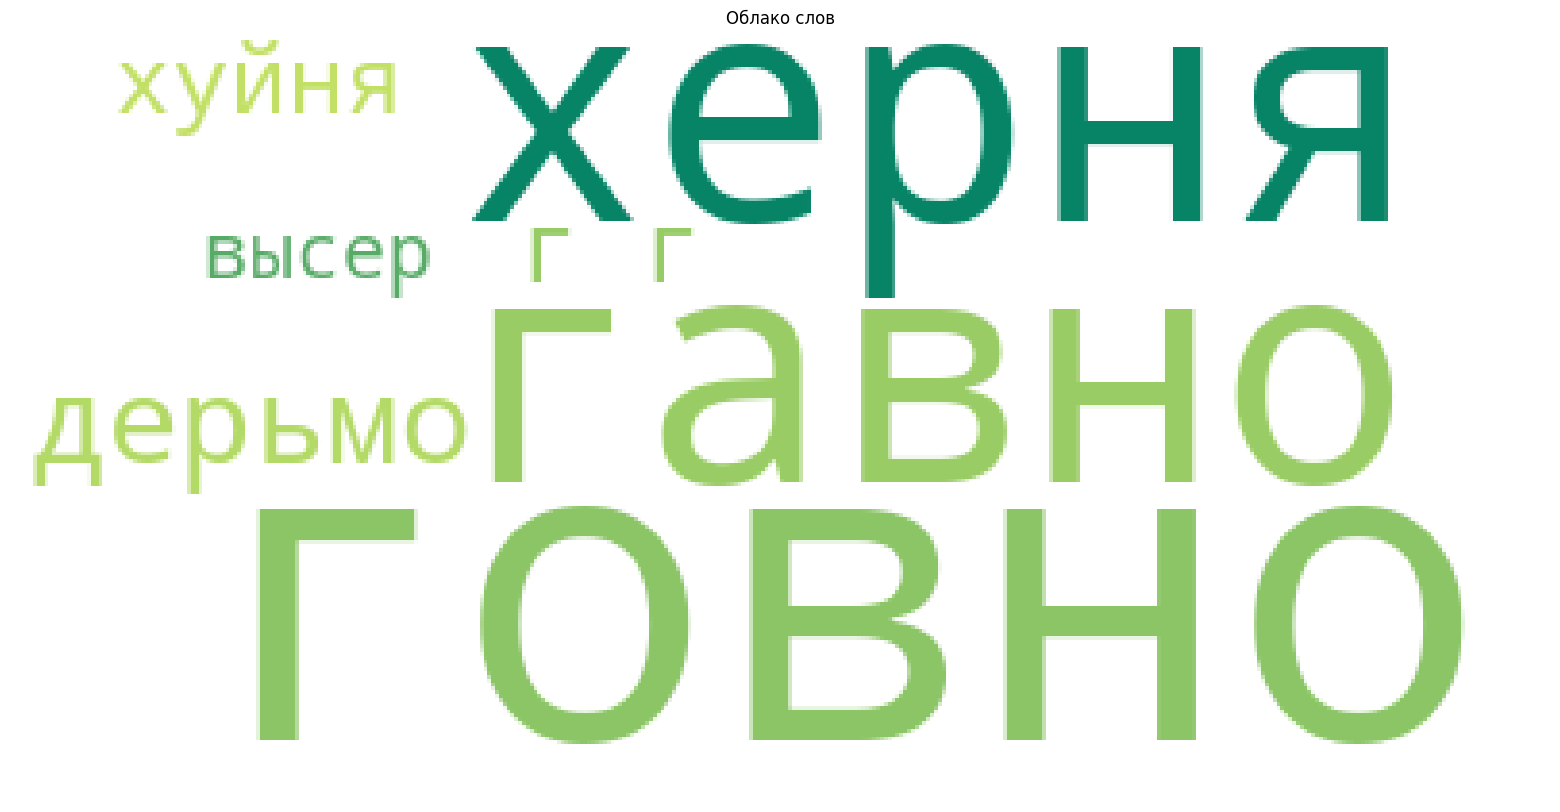

In [9]:
# облако слов

wc = WordCloud(background_color="white", max_words=200, margin=5,
               min_font_size=20, random_state=seed_val, colormap='summer')
wc.generate(data_train.label[(data_train.label.notnull())].to_string())
plt.figure(figsize=(20, 10))
plt.title("Облако слов")
plt.axis("off")
plt.imshow(wc)

In [10]:
def find_words_in_string(dictionary: dict, text: str, processing=None) -> list:
    """
    Данная функция находит находит слова из словаря в строке и возращает
    отсортированный список найденных слов
    """
    # Преобразуем текст в нижний регистр и разбиваем его на слова
    prccessed_text = text.lower().translate(
        str.maketrans('', '', string.punctuation))
    words_in_text = prccessed_text.lower().strip().split()
    
    if processing == 'staming':
        words_in_text_proc = list(map(ss.stem, words_in_text))
    elif processing == 'limatization':
        words_in_text_proc = list(map(lambda x: morph.parse(x)[0].normal_form, words_in_text))
    else:
        words_in_text_proc = words_in_text

    positions = {}
    
    for index, word in enumerate(words_in_text_proc):
        if word in vocab:
            positions[word] = index

    return sorted([words_in_text[value] for value in positions.values()])




In [28]:
# удаляем слова, которые ошибочно были занесены в словарь 

delete_words = ['полное', 'г', 'го', 'хрень', 'х'] + delete_words
delete_words_json = json.dumps(delete_words, ensure_ascii=False)
for word in delete_words:
    try:
        vocab.remove(word)
    except: continue

# delete_words = ['полное', 'полная', 'просто', 'простое', 
#                 'простой' 'г', 'го', 'хрень', 'х', 'на']
# delete_words_json = json.dumps(delete_words, ensure_ascii=False)
# for word in delete_words:
#     try:
#         vocab.remove(word)
#     except: continue

In [29]:
def test_review(vocab: set, processing=None) -> dict:
    """
    Данная функция рассчитывает расстояние Левенштейна между таргет строкой и 
    предсказанной строкой, сформированной на основе словаря, и возвращает
    среднее расстояние Левенштейна и ошибки, получившиеся в результате 
    неверных предсказаний
    """
    
    mistakes = {}
    distance = 0
    distance_mat = 0
    
    for i, row in tqdm(data_test.iterrows(), unit_scale=True):
        found_words = ",".join(find_words_in_string(vocab, row['text'], processing))
        label = row['label'] if row['label'] is not np.nan else ''
        current_distance = Levenshtein.distance(found_words, label)
        distance += current_distance

        if row['label'] is not np.nan:
            current_distance_mat =  Levenshtein.distance(found_words, label)
            distance_mat += current_distance_mat
        
        if current_distance > 0:
            if row['label'] not in mistakes.keys():
                mistakes[row['label']] = [found_words, current_distance]
            else:
                mistakes[row['label']] += [found_words, current_distance]

    mean_distance = distance / len(data_test)
    mean_distance_mat = distance_mat / len(data_test[~data_test['label'].isna()])
    
    return mistakes, mean_distance, mean_distance_mat

In [31]:
# создание и логирование эксперимента

task1 = Task.init(project_name='wb sprint2', task_name='vocab from dataset')
mistakes, mean_distance, mean_distance_mat = test_review(vocab)
print(f"Среднее расстояние Леветштейна: {mean_distance}")
print(f"Среднее расстояние Леветштейна для непустых label: {mean_distance_mat}")
task1.connect({
    'vocab': 'vocab from dataset all data',
    'vocab_size': len(vocab),
    'mean_distance': mean_distance,
    'mean_distance_mat': mean_distance_mat,
    'delete words': delete_words_json,
    'processing': '-'
})

mistakes_path = '/kaggle/working/mistakes.pkl'
with open(mistakes_path, 'wb') as f:
    pickle.dump(mistakes, f)

vocab_path = '/kaggle/working/vocab.json'
with open(vocab_path, 'w', encoding='utf-8') as f:
    json.dump(list(vocab), f, ensure_ascii=False)

task1.upload_artifact('mistakes', artifact_object='/kaggle/working/mistakes.pkl')
task1.upload_artifact('vocab', artifact_object=vocab_path)
task1.close()

48.9kit [00:04, 11.4kit/s]

Среднее расстояние Леветштейна: 0.2677535343629975
Среднее расстояние Леветштейна для непустых label: 1.8703889766039903


In [ ]:
# вывод самых частых ошибок 

sorted_keys = sorted(mistakes, key=lambda k: len(mistakes[k]), reverse=True)

# Выбираем первые 5 ключей
top_5_keys = sorted_keys[:5]

print("Ключи с самыми длинными значениями:", top_5_keys)
print("Самые длинные значения:", [mistakes[key] for key in top_5_keys])

In [ ]:
# тест модели

previous_task_id = '7e9906757e204991ae08ca0ed3e142a1'  # Замените на ID вашего предыдущего эксперимента
previous_task = Task.get_task(task_id=previous_task_id)

vocab_artifact = previous_task.artifacts['vocab']
vocab_path = vocab_artifact.get_local_copy()
with open(vocab_path, 'rb') as f:
    vocab = set(json.load(f))

label = []
for i, row in tqdm(test.iterrows(), unit_scale=True):
    found_words = ",".join(find_words_in_string(vocab, row['text']))
    label.append(found_words)

answer = test.copy().drop('text', axis=1)
answer['label'] = label
answer.to_csv('answer.csv', index=False)

### Решение задачи детекции мата с помощью обучения модели Bert для задачи классификации токенов

In [13]:
import datasets 
from datasets import Dataset, DatasetDict
import numpy as np

from transformers import BertTokenizerFast 
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
import evaluate


import re
from razdel import tokenize

import logging
from transformers.trainer import logger as noisy_logger


noisy_logger.setLevel(logging.WARNING)

def remove_emoji(text) -> str:
    """
    удаляет ээмоджи из строки
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

print(remove_emoji('👍!'))

!


In [ ]:
# скачивание обученного токенайзера

model_checkpoint = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [14]:
# разбиение текста на токены и разметка токенов на классы

tags = []
tokens = []
for i, row in tqdm(data.iterrows(), unit_scale=True):
    prccessed_text = remove_emoji(row['text']).lower()
    raw_toks = tokenizer.tokenize(prccessed_text)
    words = []
    current_word = ""
    for token in raw_toks:
        if token.startswith("##"):
            current_word += token[2:]
        else:
            if current_word:
                words.append(current_word)
            current_word = token
    if current_word:
        words.append(current_word)
    tokens.append(words)
    mat = row['label']
    if mat is not np.nan:
        tags.append(['O' if word not in mat.split(',') else 'M' if word in vocab
                     else 'O' for word in words])
    else:
        tags.append(['O' for word in words])
    
data['tags'] = tags
data['tokens'] = tokens

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


['[CLS]', 'Все', '##м', 'добро', '##го', 'времени', 'су', '##ток', '[SEP]']


4.06kit [00:01, 3.69kit/s]Token indices sequence length is longer than the specified maximum sequence length for this model (925 > 512). Running this sequence through the model will result in indexing errors
245kit [01:07, 3.62kit/s] 


,label,tags,tokens
72873,жопы,"[O, O, O, O, O, O, O, M, O, O, O, O, O]","[быстро, пришло, ,, но, все, как, из, жопы, ,, ещё, и, порезанно, .]"
152367,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...]","[купил, со, скидкой, примерно, 3, -, 3, ,, 5, тыс, ., руб, ., ,, что, ,, безусловно, ,, хорошо, ., выглядит, саундбар, приятно, ,, подключился, мгновенно, ,, обновился, через, флешку, без, проблем, ., теперь, о, менее, приятном, -, пульт, от, саундбара, почему, -, то, совпадает, с, пультом, от, тв, -, приставки, !, одна, из, кнопок, (, увеличение, звука, ), на, пульте, саундбара, переключает, тв, -, приставку, в, основное, меню, на, главном, экране, ., т, ., е, ., смотришь, кино, и, случайно, нажимаешь, кнопку, увеличения, громкости, и, ты, уже, на, главном, экране, ,, начинай, все, сначал..."
217973,NaN,"[O, O]","[кроссовки, супер]"
214295,педаргоний,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, M, O]","[помазала, 2, ., 05, цветок, и, посадила, сегодня, 14, и, 2, хороших, корня, у, педаргоний, рекомендую]"
43864,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[удивило, качество, этих, недорогих, брюк, ., посадка, удобная, ,, к, телу, приятно, ,, осталась, довольна, ., спасибо, .]"
...,...,...,...
107111,NaN,"[O, O, O, O, O, O]","[очень, милая, пижама, ., мужу, зашла]"
108352,NaN,"[O, O, O, O, O, O, O]","[не, подошёл, ,, крем, для, непроблемной, кожи]"
120625,NaN,"[O, O, O, O, O, O, O, O, O]","[маломерят, мягко, сказано, ., размеры, пишут, от, балды, .]"
158779,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[телефон, сломался, после, 3, недель, использования, в, сервис, отнёс, сказали, труп, товар, г, *, *, *, *]"


In [15]:
data[~data['label'].isna()]

,ID,text,label,tags,tokens
32,32,говно а не товар,говно,"[M, O, O, O]","[говно, а, не, товар]"
36,36,"спасибо за уёбищние шарики!такой хуйни я еще не видела!спасибо за испорченое настроение!у вас больше никогда в жизни не куплю,и другим не советую,даже одной звезды вам мало","уёбищние,хуйни","[O, O, M, O, O, O, M, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[спасибо, за, уёбищние, шарики, !, такой, хуйни, я, еще, не, видела, !, спасибо, за, испорченое, настроение, !, у, вас, больше, никогда, в, жизни, не, куплю, ,, и, другим, не, советую, ,, даже, одной, звезды, вам, мало]"
39,39,пришла какая-то х....та вы там чё курите?,х...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[пришла, какая, -, то, х, ., ., ., ., та, вы, там, чё, курите, ?]"
53,53,"полное говно, не липнет пустая трата денег",говно,"[O, M, O, O, O, O, O, O]","[полное, говно, ,, не, липнет, пустая, трата, денег]"
58,58,"на вид очень даже ничего. но хочу сказать, что по качеству полное г... прислали еще и грязную. заявленную цену оно не стоит. 🤔",г...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[на, вид, очень, даже, ничего, ., но, хочу, сказать, ,, что, по, качеству, полное, г, ., ., ., прислали, еще, и, грязную, ., заявленную, цену, оно, не, стоит, .]"
...,...,...,...,...,...
244734,248088,мне ее порвали суки,суки,"[O, O, O, M]","[мне, ее, порвали, суки]"
244735,248089,"Полное дерьмо, удалите этот товар и заблокируйте продавца",дерьмо,"[O, M, O, O, O, O, O, O, O]","[полное, дерьмо, ,, удалите, этот, товар, и, заблокируйте, продавца]"
244736,248090,Херня. Деньги на ветер.,херня,"[M, O, O, O, O, O]","[херня, ., деньги, на, ветер, .]"
244737,248091,"Это вообще что , за 💩 гов... ще?? Темнотища ужас!! Тонкая промашка 👎, рвётся, морщица и не расправляется, рисунок в некоторых местах не совпадает.. Еле от стены отшкрябала, в полном смысле. Стена новый гипсокартон, весь в краске покрасился🤦не рекомендую 👎👎👎👎 от слова СОВСЕМ!!!!",гов... ще,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[это, вообще, что, ,, за, гов, ., ., ., ще, ?, ?, темнотища, ужас, !, !, тонкая, промашка, ,, рвётся, ,, морщица, и, не, расправляется, ,, рисунок, в, некоторых, местах, не, совпадает, ., ., еле, от, стены, отшкрябала, ,, в, полном, смысле, ., стена, новый, гипсокартон, ,, весь, в, краске, покрасилсяне, рекомендую, от, слова, совсем, !, !, !, !]"


In [16]:
# разбиение данные на треин и тест. Создание объектов Dataset

data_train, data_test = train_test_split(data.drop(['ID', 'text'], axis=1), test_size=0.2)
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

ner_data = DatasetDict({
    'train': Dataset.from_pandas(data_train),
    'test': Dataset.from_pandas(data_test)
})
ner_data

DatasetDict({
    train: Dataset({
        features: ['label', 'tags', 'tokens'],
        num_rows: 195791
    })
    test: Dataset({
        features: ['label', 'tags', 'tokens'],
        num_rows: 48948
    })
})

In [17]:
label_list = ['O', 'M']
def tokenize_and_align_labels(example: pd.Serias, label_all_tokens=True):
    """
    Данная функция предназначена, чтобы создать столбцы 
    ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    предназначенные для обучения модели Bert
    """
    tokenized_inputs = tokenizer(example['tokens'], truncation=True, is_split_into_words=True)
    label = example['tags']
    
    if len(label) == 0:
        tokenized_inputs['labels'] = []
        return tokenized_inputs
        
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []
    
    for word_idx in word_ids:
        # Special tokens have a word id that is None. We set the label to -100 so they are automatically
        # ignored in the loss function.
        if word_idx is None:
            label_ids.append(-100)
        # We set the label for the first token of each word.
        elif word_idx != previous_word_idx:
            #print(word_idx, 'word_idx')
            label_ids.append(label[word_idx])
        # For the other tokens in a word, we set the label to either the current label or -100, depending on
        # the label_all_tokens flag.
        else:
            #print(word_idx, 'previous')
            label_ids.append(label[word_idx] if label_all_tokens else -100)
        previous_word_idx = word_idx

    label_ids = [label_list.index(idx) if isinstance(idx, str) else idx for idx in label_ids]
    tokenized_inputs["labels"] = label_ids
    
    return tokenized_inputs


In [18]:
# добавление необходимых столбцов и удаление ненужных для работы Bert

tokenized_datasets = ner_data.map(tokenize_and_align_labels)
tokenized_datasets = tokenized_datasets.remove_columns(['tags', 'tokens', 'label'])
tokenized_datasets

Map:   0%|          | 0/195791 [00:00<?, ? examples/s]

Map:   0%|          | 0/48948 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 195791
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 48948
    })
})

In [19]:
tokenized_datasets['train'][0]['attention_mask']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [20]:
# загрузка предобученной модели

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model.config.id2label = dict(enumerate(label_list))
model.config.label2id = {v: k for k, v in model.config.id2label.items()}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def compute_metrics(p, **kwargs):
    """
    Данная функция предназначена для подсчета метрик на тестовой выборке при
    обучении модели. Так же результы логируются в clearml
    """
    predictions, labels = p.predictions, p.label_ids
    input_ids = p.inputs
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i in range(len(true_predictions)):
        for j in range(len(true_predictions[i])):
            if true_predictions[i][j] == true_labels[i][j] == 'M':
                tp += 1
            if true_predictions[i][j] == true_labels[i][j] == 'O':
                tn += 1
            if true_predictions[i][j] == 'O' and true_labels[i][j] == 'M':
                fn += 1
            if true_predictions[i][j] == 'M' and true_labels[i][j] == 'O':
                fp += 1
                
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    try:
        recall = tp / (tp + fn)
    except:
        recall = 0
    try:
        precision = tp / (tp + fp)
    except:
        precision = 0
    try:
        f1 = 2 * recall * precision / (recall + precision)
    except: f1 = 0
        
    task.get_logger().report_scalar(title='Metrics', series='accuracy', value=accuracy, iteration=trainer.state.global_step)
    task.get_logger().report_scalar(title='Metrics', series='precision', value=precision, iteration=trainer.state.global_step)
    task.get_logger().report_scalar(title='Metrics', series='recall', value=recall, iteration=trainer.state.global_step)
    task.get_logger().report_scalar(title='Metrics', series='f1', value=f1, iteration=trainer.state.global_step)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [26]:
# создание эксперермента в clearml
task = Task.init(project_name='wb sprint2', task_name='rubert-tiny other tags')

ClearML Task: created new task id=78463bf1b0fd4806a68d26d5e7f6e49f
2024-12-08 20:34:51,247 - clearml.Repository Detection - WARNING - Jupyter Notebook auto-logging failed, could not access: /kaggle/working/__notebook_source__.ipynb
2024-12-08 20:34:51,253 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/ac60ac97556c43978ea64418f728663a/experiments/78463bf1b0fd4806a68d26d5e7f6e49f/output/log


/opt/conda/lib/python3.10/site-packages/clearml/utilities/process/mp.py:629: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-12-08 21:34:27,139 - clearml.storage - INFO - Uploading: 44.60MB to /kaggle/working/model_rubert.pth


/opt/conda/lib/python3.10/site-packages/clearml/utilities/process/mp.py:629: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

███████████████████████████████▉ 100% | 44.60/44.6 MB [00:01<00:00, 33.24MB/s]: 


In [27]:
# Обучение модели Bert

for param in model.parameters():
    param.requires_grad = True


batch_size = 32
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
args = TrainingArguments(
    "ner",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy='no',
    logging_steps=10,
    report_to=["clearml"]
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



2024-12-08 20:35:00,223 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.006400,0.006710,0.921278,0.907475,0.914324,0.998084
2,0.003000,0.005372,0.905685,0.958294,0.931247,0.998406
3,0.002300,0.004299,0.929892,0.958797,0.944123,0.998721
4,0.004300,0.004189,0.923994,0.970537,0.946694,0.998769
5,0.001300,0.003749,0.934009,0.968525,0.950954,0.998874
6,0.003600,0.003667,0.934509,0.971655,0.952720,0.998914
7,0.002000,0.003593,0.936499,0.971264,0.953565,0.998934
8,0.001900,0.003618,0.936100,0.972159,0.953789,0.998939
9,0.001500,0.003550,0.940342,0.971096,0.955472,0.998980
10,0.002100,0.003537,0.939391,0.972214,0.955521,0.998980


0.9980840028091215 0.9074747022977582 0.9212781656166639 0.9143243395482453
0.9984058550657089 0.958293732878627 0.9056853006446158 0.9312471137913236
0.9987214088436938 0.9587968915972493 0.9298920999837337 0.9441233140655105
0.9987686474332125 0.9705372616984402 0.9239940387481371 0.9466939331970007
0.9988744618737344 0.9685246268239504 0.9340090575803321 0.9509537532592288
0.9989135124410699 0.9716553921842679 0.934509086998602 0.9527202960120598
0.9989342974204581 0.9712640465142283 0.9364993800873268 0.9535649596575004
0.9989387063554799 0.9721585509028904 0.9361003445305771 0.9537887721800182
0.9989802763142563 0.9710963269413541 0.9403421394543092 0.9554718226573887
0.9989802763142563 0.9722144574271817 0.939390665514261 0.9555207560647271


TrainOutput(global_step=61190, training_loss=0.005000269566615427, metrics={'train_runtime': 3209.4682, 'train_samples_per_second': 610.042, 'train_steps_per_second': 19.065, 'total_flos': 4698435383232720.0, 'train_loss': 0.005000269566615427, 'epoch': 10.0})

In [29]:
# подсчет расстояния Ливенштейна для обученной модели

distance = 0
distance_mat = 0
k = 0
count_mat = 0

for i, row in tqdm(data_test.iterrows(), unit_scale=True):
    try:
        label = row['label'] if row['label'] is not np.nan else ''
        text = ' '.join(row['tokens'])
        tokens = tokenizer(text, return_tensors='pt')
        tokens = {k: v.to(model.device) for k, v in tokens.items()}
        with torch.no_grad():
            pred = model(**tokens)
            
        words = []
        labels = []
        current_word = []
        current_label = None
        indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
        token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
        
        for t, idx in zip(token_text, indices):
            if t.startswith("##"):
                current_word.append(t[2:])
            else:
                if current_word:
                    words.append("".join(current_word))
                    labels.append(current_label)
                current_word = [t]
                current_label = idx
        
        # Добавление последнего слова и метки
        if current_word:
            words.append("".join(current_word))
            labels.append(current_label)
            
        mats = []
        
        for word, label in zip(words, labels):
            if label_list[label] == 'M':
                mats.append(word)
                
        sorted(mats)
        predict = ",".join(mats)
        label = row['label'] if row['label'] is not np.nan else ''
        current_distance = Levenshtein.distance(predict, label)
        distance += current_distance
    
        if row['label'] is not np.nan:
            current_distance_mat = Levenshtein.distance(predict, label)
            distance_mat += current_distance_mat
            count_mat += 1
            
    except:
        k += 1
        continue

mean_distance = distance / (len(data_test) - k)
mean_distance_mat = distance_mat / count_mat

print(f"Среднее расстояние Леветштейна: {mean_distance}")
print(f"Среднее расстояние Леветштейна для непустых label: {mean_distance_mat}")

48.9kit [02:53, 281it/s]

0.3685339544005884
0.3546212306937975
12


In [30]:
task.connect({
    'mean_distance': mean_distance,
    'mean_distance_mat': mean_distance_mat,
})
model_path = '/kaggle/working/model_rubert.pth'
torch.save(model.state_dict(), model_path)
# Загрузка модели в ClearML
task.upload_artifact('model_rubert', artifact_object=model_path)
task.close()

In [31]:
tokens = []
for i, row in tqdm(test.iterrows(), unit_scale=True):
    prccessed_text = remove_emoji(row['text']).lower()
    raw_toks = tokenizer.tokenize(prccessed_text)
    words = []
    current_word = ""
    for token in raw_toks:
        if token.startswith("##"):
            current_word += token[2:]
        else:
            if current_word:
                words.append(current_word)
            current_word = token
    if current_word:
        words.append(current_word)
    tokens.append(words)
    

test['tokens'] = tokens

66.9kit [00:17, 3.73kit/s]


In [39]:
# предсказание на тестовых данных 

predictions = []

for i, row in tqdm(test.iterrows(), unit_scale=True):
    try:
        label = row['label'] if row['label'] is not np.nan else ''
        text = ' '.join(row['tokens'])
        tokens = tokenizer(text, return_tensors='pt')
        tokens = {k: v.to(model.device) for k, v in tokens.items()}
        with torch.no_grad():
            pred = model(**tokens)
        words = []
        labels = []
        current_word = []
        current_label = None
        indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
        token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
        for t, idx in zip(token_text, indices):
            if t.startswith("##"):
                current_word.append(t[2:])
            else:
                if current_word:
                    words.append("".join(current_word))
                    labels.append(current_label)
                current_word = [t]
                current_label = idx
        
        # Добавление последнего слова и метки
        if current_word:
            words.append("".join(current_word))
            labels.append(current_label)
        mats = []
        for word, label in zip(words, labels):
            if label_list[label] == 'M':
                mats.append(word)
        sorted(mats)
        predict = ",".join(mats)
        if predict == '':
             predictions.append(np.nan)
        else:
            predictions.append(predict)
    except:
        predictions.append(np.nan)
        continue

test['label'] = predictions

66.9kit [03:50, 290it/s]


In [40]:
test

,ID,text,tokens,label
0,0,"хороший, подошкл","[хороший, ,, подошкл]",NaN
1,1,"совсем тонюсенький саженец, не досмотрела в описании, что он годовалый:(","[совсем, тонюсенький, саженец, ,, не, досмотрела, в, описании, ,, что, он, годовалый, :, (]",NaN
2,2,"когтеточка хорошая, но вот ткань на основании плохо приклеяна, пришлось доделывать чтоб мех не столз. кошаки осваивают.","[когтеточка, хорошая, ,, но, вот, ткань, на, основании, плохо, приклеяна, ,, пришлось, доделывать, чтоб, мех, не, столз, ., кошаки, осваивают, .]",NaN
3,3,"много затяжек, не порадовала покупка","[много, затяжек, ,, не, порадовала, покупка]",NaN
4,4,рекомендую 💣,[рекомендую],NaN
...,...,...,...,...
66944,71995,"Пачка как пачка а внутри совсем другое \nНекторве мелкие , почти как напалечник \nВ пачке из трех один более мение \nВообщем говно","[пачка, как, пачка, а, внутри, совсем, другое, некторве, мелкие, ,, почти, как, напалечник, в, пачке, из, трех, один, более, мение, вообщем, говно]",говно
66945,71996,"Отвратительное качество!!! Через год тряпка, у супруга есть разных производителей нижнее белье, которое и по 3-5лет в приличном состоянии остаётся), но это просто швах!!!!! Продавец, имейте совесть, за такие деньги такое г… о!! Ну прям не честно!!!","[отвратительное, качество, !, !, !, через, год, тряпка, ,, у, супруга, есть, разных, производителей, нижнее, белье, ,, которое, и, по, 3, -, 5лет, в, приличном, состоянии, остаётся, ), ,, но, это, просто, швах, !, !, !, !, !, продавец, ,, имейте, совесть, ,, за, такие, деньги, такое, г, [UNK], о, !, !, ну, прям, не, честно, !, !, !]",NaN
66946,71997,"Вес 100гр, не понимаю откуда хорошие отзывы , полное г...","[вес, 100гр, ,, не, понимаю, откуда, хорошие, отзывы, ,, полное, г, ., ., .]",NaN
66947,71998,"Приобрел и установил радиатор год назад , автомобиль практически не выезжал , летом заметил подтёки подумал что патрубок капает , но оказалось течет сам радиатор , до этого стоял такой же отработал лет 8 без проблем \nКачество стало полное говно к покупке не рекомендую лучше взять что-то лучше в идеале медный , но там ценник конский \nПроизводителю хочется пожелать здоровья и таких же качественных запчастей на его автомобиль","[приобрел, и, установил, радиатор, год, назад, ,, автомобиль, практически, не, выезжал, ,, летом, заметил, подтёки, подумал, что, патрубок, капает, ,, но, оказалось, течет, сам, радиатор, ,, до, этого, стоял, такой, же, отработал, лет, 8, без, проблем, качество, стало, полное, говно, к, покупке, не, рекомендую, лучше, взять, что, -, то, лучше, в, идеале, медный, ,, но, там, ценник, конский, производителю, хочется, пожелать, здоровья, и, таких, же, качественных, запчастей, на, его, автомобиль]",говно


In [41]:
test[['ID', 'label']].to_csv('answer12.csv', index=False)

In [69]:
test

,ID,text,tokens,label
0,0,"хороший, подошкл","[хороший, ,, подошкл]",NaN
1,1,"совсем тонюсенький саженец, не досмотрела в описании, что он годовалый:(","[совсем, тонюсенький, саженец, ,, не, досмотрела, в, описании, ,, что, он, годовалый, :, (]",NaN
2,2,"когтеточка хорошая, но вот ткань на основании плохо приклеяна, пришлось доделывать чтоб мех не столз. кошаки осваивают.","[когтеточка, хорошая, ,, но, вот, ткань, на, основании, плохо, приклеяна, ,, пришлось, доделывать, чтоб, мех, не, столз, ., кошаки, осваивают, .]",NaN
3,3,"много затяжек, не порадовала покупка","[много, затяжек, ,, не, порадовала, покупка]",NaN
4,4,рекомендую 💣,[рекомендую],NaN
...,...,...,...,...
66944,71995,"Пачка как пачка а внутри совсем другое \nНекторве мелкие , почти как напалечник \nВ пачке из трех один более мение \nВообщем говно","[пачка, как, пачка, а, внутри, совсем, другое, некторве, мелкие, ,, почти, как, напалечник, в, пачке, из, трех, один, более, мение, вообщем, говно]",говно
66945,71996,"Отвратительное качество!!! Через год тряпка, у супруга есть разных производителей нижнее белье, которое и по 3-5лет в приличном состоянии остаётся), но это просто швах!!!!! Продавец, имейте совесть, за такие деньги такое г… о!! Ну прям не честно!!!","[отвратительное, качество, !, !, !, через, год, тряпка, ,, у, супруга, есть, разных, производителей, нижнее, белье, ,, которое, и, по, 3, -, 5лет, в, приличном, состоянии, остаётся, ), ,, но, это, просто, швах, !, !, !, !, !, продавец, ,, имейте, совесть, ,, за, такие, деньги, такое, г, [UNK], о, !, !, ну, прям, не, честно, !, !, !]",NaN
66946,71997,"Вес 100гр, не понимаю откуда хорошие отзывы , полное г...","[вес, 100гр, ,, не, понимаю, откуда, хорошие, отзывы, ,, полное, г, ., ., .]",NaN
66947,71998,"Приобрел и установил радиатор год назад , автомобиль практически не выезжал , летом заметил подтёки подумал что патрубок капает , но оказалось течет сам радиатор , до этого стоял такой же отработал лет 8 без проблем \nКачество стало полное говно к покупке не рекомендую лучше взять что-то лучше в идеале медный , но там ценник конский \nПроизводителю хочется пожелать здоровья и таких же качественных запчастей на его автомобиль","[приобрел, и, установил, радиатор, год, назад, ,, автомобиль, практически, не, выезжал, ,, летом, заметил, подтёки, подумал, что, патрубок, капает, ,, но, оказалось, течет, сам, радиатор, ,, до, этого, стоял, такой, же, отработал, лет, 8, без, проблем, качество, стало, полное, говно, к, покупке, не, рекомендую, лучше, взять, что, -, то, лучше, в, идеале, медный, ,, но, там, ценник, конский, производителю, хочется, пожелать, здоровья, и, таких, же, качественных, запчастей, на, его, автомобиль]",говно
